In [ ]:
# NEU-DET Dataset
from google.colab import files
import zipfile, os

uploaded = files.upload()
zip = list(uploaded.keys())[0]
dir = "NEU_Surface_Defects"
os.makedirs(dir, exist_ok=True)
with zipfile.ZipFile(zip, "r") as zip_ref:
    zip_ref.extractall(dir)

# Masire sahihe pusheha
train_images_dir = os.path.join(dir, "NEU-DET", "train", "images")
val_images_dir   = os.path.join(dir, "NEU-DET", "validation", "images")

# Sehate vujude dadeha
if not (os.path.isdir(train_images_dir) and os.path.isdir(val_images_dir)):
    for root, dirs, files in os.walk(dir):
        print(f" {root} --> {dirs}")
    raise ValueError("Pusheha peyda nashodand")
else:
    print(f"Masire sahih peida shod: \n  Amuzesh: {train_images_dir}\n  Azmoon: {val_images_dir}")

# Bargozarie dadeha ba image_dataset_from_directory
import tensorflow as tf

img_height, img_width = 200, 200
batch_size = 1800  # Kole dadeha yekja

train_ds = tf.keras.utils.image_dataset_from_directory(train_images_dir,labels="inferred",
                                                       label_mode="int",color_mode="grayscale",
                                                       batch_size=batch_size,
                                                       image_size=(img_height, img_width),
                                                       shuffle=True,seed=42,)

val_ds = tf.keras.utils.image_dataset_from_directory(val_images_dir,labels="inferred",
                                                     label_mode="int",color_mode="grayscale",
                                                     batch_size=batch_size,
                                                     image_size=(img_height, img_width),
                                                     shuffle=False,)

# Tabdil be NumPy
for images, labels in train_ds.take(1):
    X_train = images.numpy()
    y_train = labels.numpy()

for images, labels in val_ds.take(1):
    X_test = images.numpy()
    y_test = labels.numpy()

# Normalsazi
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Abaade nahayi
print(f"Training set shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation/Test set shape: {X_test.shape}, Labels: {y_test.shape}")


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

print(y_train_cat.shape)
print(y_test_cat.shape)

(1440, 6)
(360, 6)


In [ ]:
from tensorflow.keras import layers, models, optimizers

mlp_model = models.Sequential([
    layers.Input(shape=(200, 200, 1)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])

adam_optimizer = optimizers.Adam(learning_rate=0.001)

mlp_model.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = mlp_model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,
    batch_size=32
)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.1805 - loss: 17.9118 - val_accuracy: 0.1694 - val_loss: 2.5607
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1909 - loss: 3.0125 - val_accuracy: 0.2028 - val_loss: 1.7474
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1983 - loss: 1.7829 - val_accuracy: 0.2389 - val_loss: 1.7231
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1727 - loss: 1.7620 - val_accuracy: 0.1667 - val_loss: 1.7666
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2089 - loss: 1.7496 - val_accuracy: 0.1583 - val_loss: 1.7162
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2045 - loss: 1.7271 - val_accuracy: 0.2472 - val_loss: 1.6940
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2207 - loss: 1.7049 - val_accuracy: 0.2472 - val_loss: 1.6777
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2221 - loss: 1.7048 - val_accuracy: 0.1694 - val_los

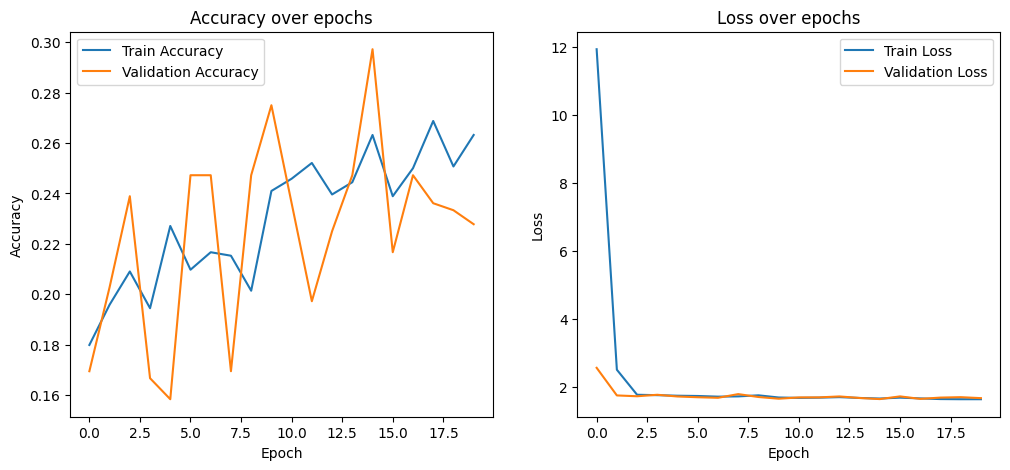

Test accuracy: 22.78%
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


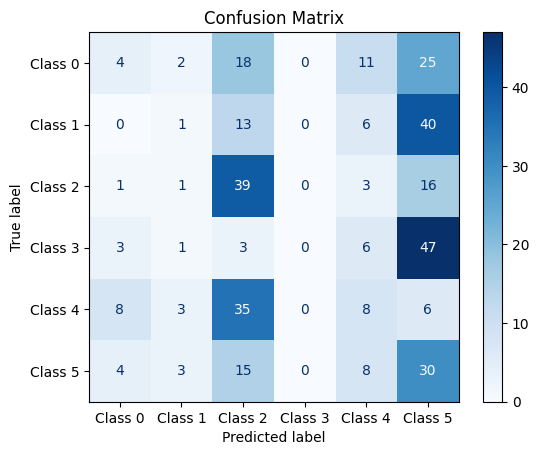

In [ ]:
import matplotlib.pyplot as plt

# Nemudare deghat
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Nemudare khata
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
test_loss, test_accuracy = mlp_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test accuracy: {test_accuracy*100:.2f}%")
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pishbinie classha ruye dadeye test
y_pred_probs = mlp_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Matrix ashoftegi
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Class {i}' for i in range(6)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# from tensorflow.keras import layers, models, optimizers
# from tensorflow.keras.callbacks import EarlyStopping

# mlp_model = models.Sequential([
#     layers.Input(shape=(200, 200, 1)),
#     layers.Resizing(64, 64),
#     layers.Flatten(),

#     layers.Dense(128),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.3),

#     layers.Dense(64),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.3),

#     layers.Dense(6, activation='softmax')
# ])


# mlp_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

# early_stop = EarlyStopping(patience=10, restore_best_weights=True)
# history = mlp_model.fit(X_train, y_train,
#                         validation_data=(X_test, y_test),
#                         epochs=50,
#                         batch_size=32,
#                         callbacks=[early_stop])
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,5))

# plt.subplot(1,2,1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Val Accuracy')
# plt.title("Accuracy per Epoch")
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.title("Loss per Epoch")
# plt.legend()

# plt.show()
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import numpy as np

# y_pred = mlp_model.predict(X_test)
# y_pred_labels = np.argmax(y_pred, axis=1)

# cm = confusion_matrix(y_test, y_pred_labels)
# disp = ConfusionMatrixDisplay(cm)
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix")
# plt.show()


In [16]:
# from tensorflow.keras import layers, models, optimizers
# from tensorflow.keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import numpy as np

# cnn_model = models.Sequential([
#     layers.Input(shape=(200, 200, 1)),

#     layers.Resizing(128, 128),  # کاهش ابعاد برای مدیریت حافظه

#     layers.Conv2D(32, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),


#     layers.Conv2D(64, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.3),


#     layers.Conv2D(128, (3, 3), padding='same'),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.4),


#     layers.Flatten(),
#     layers.Dense(128),
#     layers.BatchNormalization(),
#     layers.Activation('relu'),
#     layers.Dropout(0.5),

#     layers.Dense(6, activation='softmax')
# ])

# cnn_model.compile(
#     optimizer=optimizers.Adam(learning_rate=0.001),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# early_stop = EarlyStopping(patience=7, restore_best_weights=True)

# history = cnn_model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=50,
#     batch_size=32,
#     callbacks=[early_stop]
# )

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Train Acc')
# plt.plot(history.history['val_accuracy'], label='Val Acc')
# plt.legend(); plt.title('Accuracy per Epoch')

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.legend(); plt.title('Loss per Epoch')
# plt.show()

# # Confusion Matrix
# y_pred = cnn_model.predict(X_test)
# y_pred_labels = np.argmax(y_pred, axis=1)

# cm = confusion_matrix(y_test, y_pred_labels)
# disp = ConfusionMatrixDisplay(cm)
# disp.plot(cmap="Blues")
# plt.title("Confusion Matrix")
# plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Tabdile y_train , y_test be one-hot
y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

model = Sequential()

# Block1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # 6 کلاس

# Compile model ba categorical_crossentropy
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Amuzesh
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,
    batch_size=32,
    verbose=2
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,575,366 (78.49 MB)

 Trainable params: 20,574,918 (78.49 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
45/45 - 21s - 457ms/step - accuracy: 0.6160 - loss: 26.3987 - val_accuracy: 0.1667 - val_loss: 149.3757
Epoch 2/20
45/45 - 5s - 109ms/step - accuracy: 0.7014 - loss: 9.2118 - val_accuracy: 0.1667 - val_loss: 159.8872
Epoch 3/20
45/45 - 2s - 53ms/step - accuracy: 0.6889 - loss: 2.6539 - val_accuracy: 0.1667 - val_loss: 165.8598
Epoch 4/20
45/45 - 3s - 57ms/step - accuracy: 0.6604 - loss: 1.0407 - val_accuracy: 0.1667 - val_loss: 152.3388
Epoch 5/20
45/45 - 2s - 49ms/step - accuracy: 0.6722 - loss: 0.8327 - val_accuracy: 0.1667 - val_loss: 137.4172
Epoch 6/20
45/45 - 3s - 56ms/step - accuracy: 0.6938 - loss: 0.8237 - val_accuracy: 0.1667 - val_loss: 129.9381
Epoch 7/20
45/45 - 2s - 55ms/step - accuracy: 0.6986 - loss: 0.7576 - val_accuracy: 0.1667 - val_loss: 112.7870
Epoch 8/20
45/45 - 2s - 49ms/step - accuracy: 0.7458 - loss: 0.6878 - val_accuracy: 0.1667 - val_loss: 110.5494
Epoch 9/20
45/45 - 3s - 56ms/step - accuracy: 0.7451 - loss: 0.7913 - val_accuracy: 0.1667 - val_los

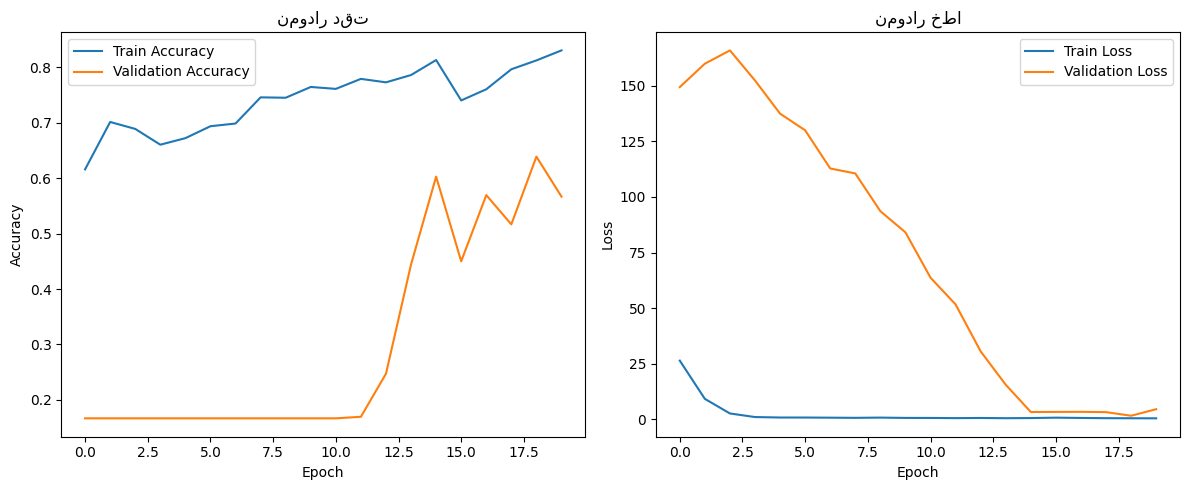

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Deghat
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('نمودار دقت')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Khata
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('نمودار خطا')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12,5))

# plt.subplot(1,2,1)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss over epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.show()


In [ ]:
from tensorflow.keras.utils import to_categorical

y_test_cat = to_categorical(y_test, num_classes=6)
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f" دقت نهایی مدل روی داده‌های آزمون: {test_accuracy * 100:.2f}%")


🎯 دقت نهایی مدل روی داده‌های آزمون: 56.67%


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


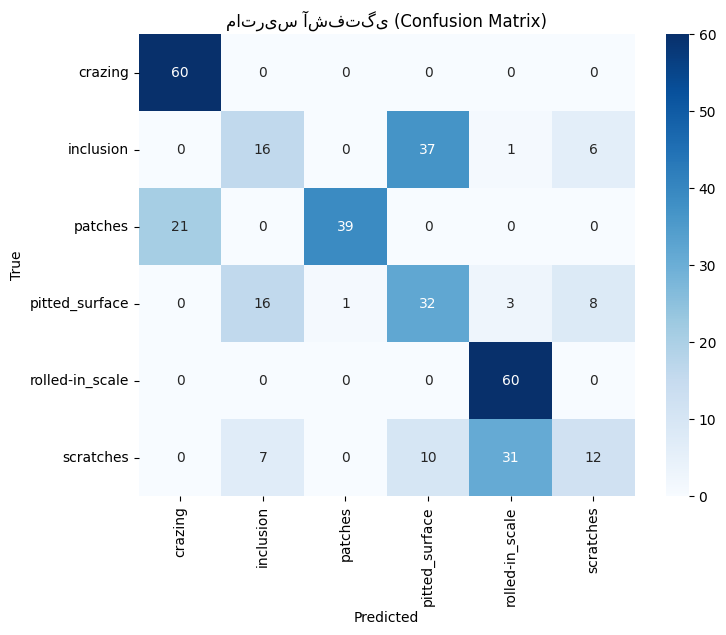

📋 Classification Report:
                 precision    recall  f1-score   support

        crazing       0.74      1.00      0.85        60
      inclusion       0.41      0.27      0.32        60
        patches       0.97      0.65      0.78        60
 pitted_surface       0.41      0.53      0.46        60
rolled-in_scale       0.63      1.00      0.77        60
      scratches       0.46      0.20      0.28        60

       accuracy                           0.61       360
      macro avg       0.60      0.61      0.58       360
   weighted avg       0.60      0.61      0.58       360



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Pishbini ruye dadehaye azmoon
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Matrix ashoftegi
cm = confusion_matrix(y_true, y_pred)
labels = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ماتریس آشفتگی (Confusion Matrix)")
plt.show()

print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [18]:
from tensorflow.keras.layers import SpatialDropout2D

model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))


model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))

# Fully connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    verbose=2
)


Epoch 1/20
45/45 - 10s - 213ms/step - accuracy: 0.5090 - loss: 23.3934 - val_accuracy: 0.2278 - val_loss: 42.3366
Epoch 2/20
45/45 - 5s - 117ms/step - accuracy: 0.5236 - loss: 5.0283 - val_accuracy: 0.1667 - val_loss: 83.8222
Epoch 3/20
45/45 - 2s - 55ms/step - accuracy: 0.4083 - loss: 1.7286 - val_accuracy: 0.1667 - val_loss: 95.7784
Epoch 4/20
45/45 - 2s - 51ms/step - accuracy: 0.4104 - loss: 1.5912 - val_accuracy: 0.1667 - val_loss: 114.9981
Epoch 5/20
45/45 - 2s - 51ms/step - accuracy: 0.4882 - loss: 1.2861 - val_accuracy: 0.1667 - val_loss: 100.6921
Epoch 6/20
45/45 - 2s - 46ms/step - accuracy: 0.5035 - loss: 1.2938 - val_accuracy: 0.1667 - val_loss: 97.4564
Epoch 7/20
45/45 - 3s - 56ms/step - accuracy: 0.5278 - loss: 1.1394 - val_accuracy: 0.1667 - val_loss: 102.8309
Epoch 8/20
45/45 - 2s - 47ms/step - accuracy: 0.5097 - loss: 1.1235 - val_accuracy: 0.1667 - val_loss: 79.4282
Epoch 9/20
45/45 - 3s - 57ms/step - accuracy: 0.5236 - loss: 1.1027 - val_accuracy: 0.1722 - val_loss: 50

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SpatialDropout2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)

model = Sequential()


model.add(Conv2D(32, (3, 1), activation='relu', input_shape=(200, 200, 1), padding='same'))
model.add(Conv2D(32, (1, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))


model.add(Conv2D(64, (3, 1), activation='relu', padding='same'))
model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))


model.add(Conv2D(128, (3, 1), activation='relu', padding='same'))
model.add(Conv2D(128, (1, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(SpatialDropout2D(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,
    batch_size=32,
    verbose=2
)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 200, 200, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 200, 200, 32)   │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 200, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 100, 100, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 100, 100, 64)   │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 100, 100, 64)   │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_4             │ (None, 50, 50, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 50, 50, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 50, 50, 128)    │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_5             │ (None, 25, 25, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │    20,480,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,578,470 (78.50 MB)

 Trainable params: 20,578,022 (78.50 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
45/45 - 23s - 515ms/step - accuracy: 0.4764 - loss: 15.3413 - val_accuracy: 0.1667 - val_loss: 38.9404
Epoch 2/20
45/45 - 9s - 200ms/step - accuracy: 0.4542 - loss: 1.9560 - val_accuracy: 0.1528 - val_loss: 56.0181
Epoch 3/20
45/45 - 5s - 113ms/step - accuracy: 0.5069 - loss: 1.3927 - val_accuracy: 0.1667 - val_loss: 79.4787
Epoch 4/20
45/45 - 5s - 110ms/step - accuracy: 0.5472 - loss: 1.1808 - val_accuracy: 0.1667 - val_loss: 89.6115
Epoch 5/20
45/45 - 5s - 114ms/step - accuracy: 0.5479 - loss: 1.1420 - val_accuracy: 0.1667 - val_loss: 96.5054
Epoch 6/20
45/45 - 5s - 115ms/step - accuracy: 0.5035 - loss: 1.1881 - val_accuracy: 0.1667 - val_loss: 95.5611
Epoch 7/20
45/45 - 3s - 74ms/step - accuracy: 0.4965 - loss: 1.2017 - val_accuracy: 0.1667 - val_loss: 93.3838
Epoch 8/20
45/45 - 3s - 77ms/step - accuracy: 0.4917 - loss: 1.0839 - val_accuracy: 0.1667 - val_loss: 74.2160
Epoch 9/20
45/45 - 3s - 75ms/step - accuracy: 0.5514 - loss: 1.1777 - val_accuracy: 0.1389 - val_loss: 5

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=6)
y_test_cat = to_categorical(y_test, num_classes=6)


model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))


datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)


model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_test, y_test_cat),
    epochs=40,
    verbose=2
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 - 131s - 3s/step - accuracy: 0.4875 - loss: 11.0918 - val_accuracy: 0.1667 - val_loss: 58.7910
Epoch 2/40
45/45 - 127s - 3s/step - accuracy: 0.6389 - loss: 1.1957 - val_accuracy: 0.1667 - val_loss: 84.8249
Epoch 3/40
45/45 - 132s - 3s/step - accuracy: 0.6451 - loss: 1.0344 - val_accuracy: 0.1667 - val_loss: 77.3960
Epoch 4/40
45/45 - 130s - 3s/step - accuracy: 0.6542 - loss: 0.9625 - val_accuracy: 0.1667 - val_loss: 70.1174
Epoch 5/40
45/45 - 140s - 3s/step - accuracy: 0.6771 - loss: 0.8645 - val_accuracy: 0.1667 - val_loss: 60.4545
Epoch 6/40
45/45 - 132s - 3s/step - accuracy: 0.7146 - loss: 0.7562 - val_accuracy: 0.3278 - val_loss: 41.8444
Epoch 7/40
45/45 - 136s - 3s/step - accuracy: 0.7243 - loss: 0.7625 - val_accuracy: 0.1667 - val_loss: 40.6388
Epoch 8/40
45/45 - 141s - 3s/step - accuracy: 0.7167 - loss: 0.7665 - val_accuracy: 0.2889 - val_loss: 47.5310
Epoch 9/40
45/45 - 149s - 3s/step - accuracy: 0.6861 - loss: 0.7629 - val_accuracy: 0.3028 - val_loss: 51.2314
Epoch 10/40